# Indian Liver Patient Records
## Author: Petr Smilek

## Introduction to the problem
Patients with Liver disease have been continuously increasing because of excessive consumption of alcohol, inhale of harmful gases, intake of contaminated food, pickles and drugs. This dataset was used to evaluate prediction algorithms in an effort to reduce burden on doctors. \
Available on kaggle - https://www.kaggle.com/uciml/indian-liver-patient-records

### Task
Use patient records to determine which patients have liver disease and which ones do not.

### Data
This data set contains 416 liver patient records and 167 non liver patient records collected from North East of Andhra Pradesh, India. The "Dataset" column is a class label used to divide groups into liver patient (liver disease) or not (no disease). This data set contains 441 male patient records and 142 female patient records. Any patient whose age exceeded 89 is listed as being of age "90".

Columns:

Age of the patient \
Gender of the patient \
Total Bilirubin \
Direct Bilirubin \
Alkaline Phosphotase \
Alamine Aminotransferase \
Aspartate Aminotransferase \
Total Protiens \
Albumin \
Albumin and Globulin Ratio

Dataset: field used to split the data into two sets (patient with liver disease, or no disease)

In [1]:
# Import relevent libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation from Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Ignore warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis (EDA)

In [2]:
raw = pd.read_csv("indian_liver_patient.csv")
raw.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
raw.shape

(583, 11)

In [4]:
raw.isna().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

We have only 4 missing values in the entire data and in this case we will remove them. 

In [5]:
df = raw.dropna() # create a new dataframe without missing values
df.shape

(579, 11)

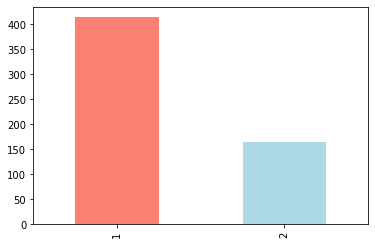

In [6]:
df["Dataset"].value_counts().plot(kind="bar",color=["salmon","lightblue"]);

Dataset 1 - patients with liver disease \
Dataset 2 - patiens without liver disease.

### Disease Acording to Gender

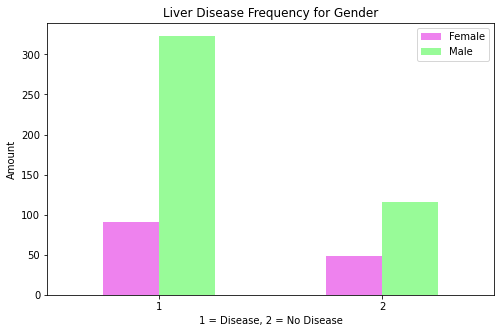

In [7]:
# Create a plot for crosstab
pd.crosstab(df.Dataset,df.Gender).plot(kind="bar",
                                      figsize=(8,5),
                                      color=["violet","palegreen"])

plt.title("Liver Disease Frequency for Gender")
plt.xlabel("1 = Disease, 2 = No Disease")
plt.ylabel("Amount")
plt.legend(["Female","Male"])
plt.xticks(rotation=0);

In [8]:
# Calculate a percentage of patients with (or without) disease according to gender

all_males = len(df.loc[df.Gender=="Male"])
males_without_disease = len(df.loc[(df.Gender=="Male") & (df.Dataset==2)])

all_females = len(df.loc[df.Gender=="Female"])
females_without_disease = len(df.loc[(df.Gender=="Female") & (df.Dataset==2)])

males_prob = (all_males - males_without_disease) / all_males
females_prob = (all_females - females_without_disease) / all_females

print(f"Percentage of males with liver disease is {males_prob*100:.2f} % and percentage of females with liver disease is {females_prob*100:.2f} %.")

Percentage of males with liver disease is 73.58 % and percentage of females with liver disease is 65.00 %.


Males are slightly more likely to have the liver disease. Now we will investigate whether some features are correlated.

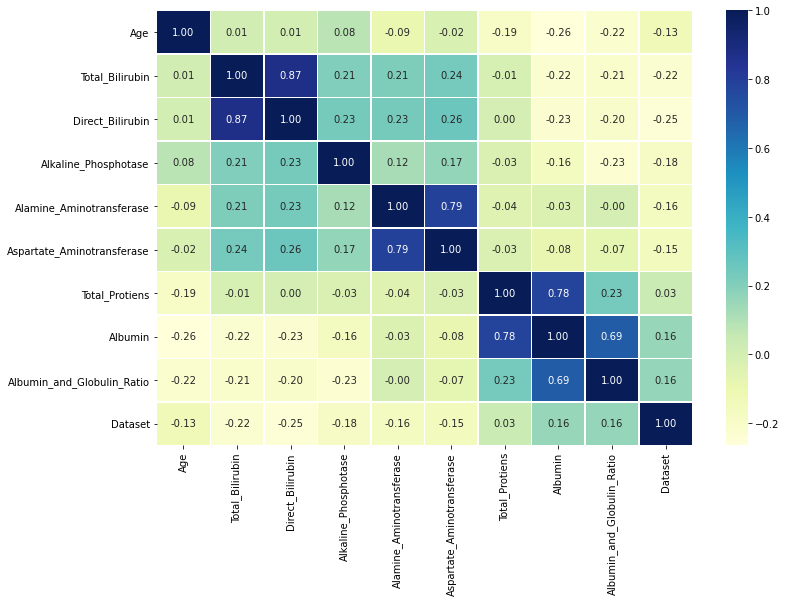

In [9]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

Yes, there are features that are strongly correlated; for example `Total_Bilirubin` and `Direct_Bilirubin`, `Alamine_Aminotransferase` and `Aspartate_Aminotransferase`, `Total_Proteins and Albumin`. We will remove some columns to avoid problem of multicolinearity later.

### Amount of Bilirubin vs Age for Liver Disease

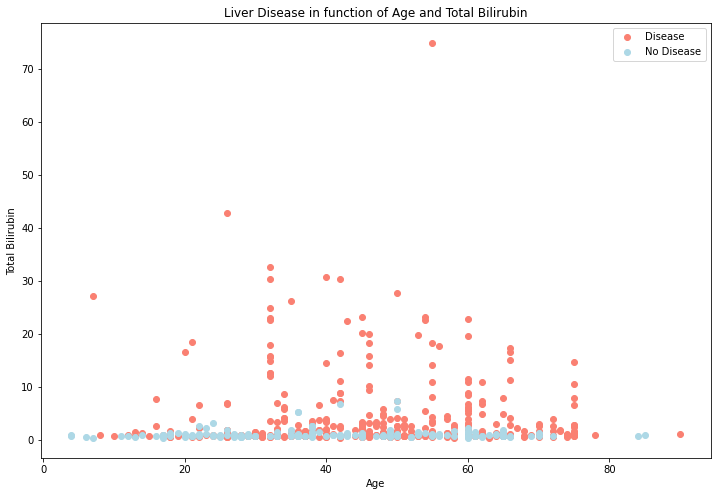

In [10]:
# Plot Bilirubin vs Age
plt.figure(figsize=(12,8))

plt.scatter(df.Age[df.Dataset==1],
           df.Total_Bilirubin[df.Dataset==1],
           c="salmon")

plt.scatter(df.Age[df.Dataset==2],
           df.Total_Bilirubin[df.Dataset==2],
           c="lightblue")

plt.title("Liver Disease in function of Age and Total Bilirubin")
plt.xlabel("Age")
plt.ylabel("Total Bilirubin")
plt.legend(["Disease", "No Disease"]);

### Alamine Aminotransferase vs Age for Liver Disease

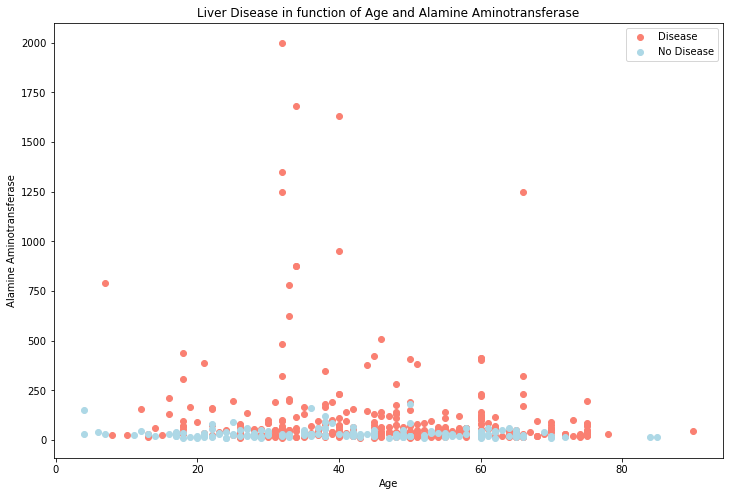

In [11]:
# Plot Alamine Aminotransferase vs Age
plt.figure(figsize=(12,8))

plt.scatter(df.Age[df.Dataset==1],
           df.Alamine_Aminotransferase[df.Dataset==1],
           c="salmon")

plt.scatter(df.Age[df.Dataset==2],
           df.Alamine_Aminotransferase[df.Dataset==2],
           c="lightblue")

plt.title("Liver Disease in function of Age and Alamine Aminotransferase")
plt.xlabel("Age")
plt.ylabel("Alamine Aminotransferase")
plt.legend(["Disease", "No Disease"]);

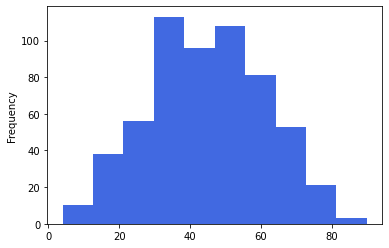

In [12]:
# The distribution of the age column
df.Age.plot.hist(color="royalblue");

## Modelling
In this part we are going to create three models:

* Logistic Regression
* KNN
* Random Forest Classifier

First, we will split the data into training and testing set. Second, all features will be transformed into numbers. Third, we will evaluate our models using different metrics such as:

* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         579 non-null    int64  
 1   Gender                      579 non-null    object 
 2   Total_Bilirubin             579 non-null    float64
 3   Direct_Bilirubin            579 non-null    float64
 4   Alkaline_Phosphotase        579 non-null    int64  
 5   Alamine_Aminotransferase    579 non-null    int64  
 6   Aspartate_Aminotransferase  579 non-null    int64  
 7   Total_Protiens              579 non-null    float64
 8   Albumin                     579 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     579 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 54.3+ KB


In [14]:
# Create feature vector and target
X = df.drop("Dataset",axis=1)
y= df["Dataset"]

# Split the data
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Check shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((463, 10), (116, 10), (463,), (116,))

All the features are in fact numbers except for *Gender*. Because we need only numbers before machine learning algorithms can be used we employ dummy variables.

In [15]:
# Encode Gender column into integers
X_train_dummies = pd.get_dummies(X_train.Gender) # get the binary dummies for gender column 
X_test_dummies = pd.get_dummies(X_test.Gender)

X_train = pd.concat((X_train,X_train_dummies),axis=1) # join dummies into dataframe
X_test = pd.concat((X_test,X_test_dummies),axis=1)
X_train = X_train.drop(["Gender","Male"],axis=1) # drop unnesesary columns
X_test = X_test.drop(["Gender","Male"],axis=1)
X_train.rename(columns={"Female":"Sex"}, inplace=True) # rename Female for Sex (1 = female, 0 = male)
X_test.rename(columns={"Female":"Sex"}, inplace=True)

X_train.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Sex
75,29,0.7,0.1,162,52,41,5.2,2.5,0.9,1
544,54,5.5,3.2,350,67,42,7.0,3.2,0.8,1
118,32,15.9,7.0,280,1350,1600,5.6,2.8,1.0,0
323,12,0.8,0.2,302,47,67,6.7,3.5,1.1,0
280,58,0.8,0.2,123,56,48,6.0,3.0,1.0,0


Now we will remove features which are strongly correlated.

In [16]:
# Remove correlated columns

X_train = X_train.drop(["Direct_Bilirubin","Aspartate_Aminotransferase","Total_Protiens","Albumin_and_Globulin_Ratio"],axis=1)
X_test = X_test.drop(["Direct_Bilirubin","Aspartate_Aminotransferase","Total_Protiens","Albumin_and_Globulin_Ratio"],axis=1)
X_train.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Albumin,Sex
75,29,0.7,162,52,2.5,1
544,54,5.5,350,67,3.2,1
118,32,15.9,280,1350,2.8,0
323,12,0.8,302,47,3.5,0
280,58,0.8,123,56,3.0,0


We are ready to fit the model!

### Model Comparison

In [17]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : dict of different models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    
    np.random.seed(42)
    
    model_scores = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores

In [18]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'Logistic Regression': 0.6379310344827587,
 'KNN': 0.6293103448275862,
 'Random Forest': 0.6379310344827587}

Wow, all the models have about the same level of accuracy (default). It would be interesting to use other metrics for comparison.

## Evaluating Models

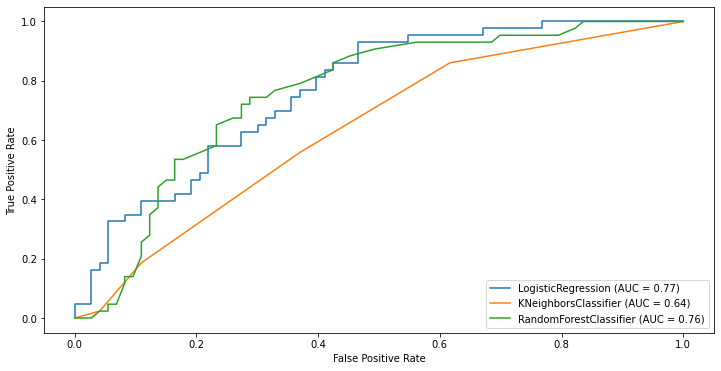

In [19]:
# Plot ROC curves in one graph
classifiers = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier()]

fig, ax = plt.subplots(figsize=(12,6))
ax = plt.gca()
for clf in classifiers:
    plot_roc_curve(clf.fit(X_train,y_train), X_test, y_test, ax=ax)

plt.savefig('ROC_graphs.png', dpi=200)

Logistic Regression has the best AUC score, very slightly better than Random Forest Classifier.

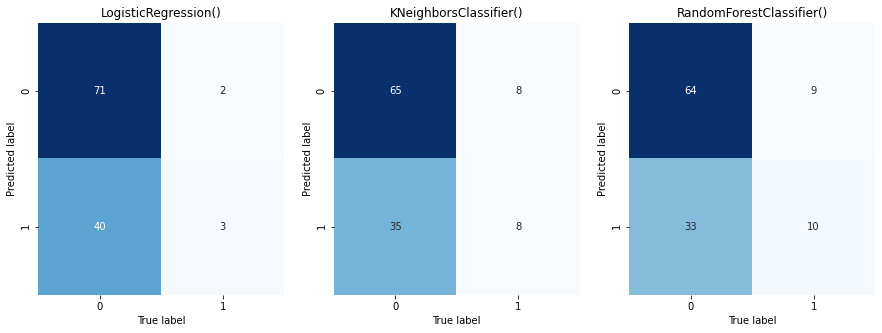

In [20]:
# Plot confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

classifiers = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier()]
predictions = []

for clf in classifiers:
    clf_fitted = clf.fit(X_train,y_train)
    y_preds = clf_fitted.predict(X_test)
    predictions.append(y_preds)
    
count = 0
while count<3:
    sns.heatmap(confusion_matrix(y_test, predictions[count]),
            annot=True,
            cbar=False,
            cmap="Blues",
            ax=axes[count])
    
    axes[count].set(title=str(classifiers[count]),
              xlabel="True label",
              ylabel="Predicted label")
    count += 1

All our models perform very poorly in predicting false positives (people classified with disease by a model but actually they were perfectly healthy).

#### Classification Report for Logistic Regression

In [21]:
y_preds = LogisticRegression().fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.64      0.97      0.77        73
           2       0.60      0.07      0.12        43

    accuracy                           0.64       116
   macro avg       0.62      0.52      0.45       116
weighted avg       0.62      0.64      0.53       116



#### Classification Report for KNN

In [22]:
y_preds = KNeighborsClassifier().fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.65      0.89      0.75        73
           2       0.50      0.19      0.27        43

    accuracy                           0.63       116
   macro avg       0.57      0.54      0.51       116
weighted avg       0.59      0.63      0.57       116



#### Classification Report forRandomForest Classifier

In [23]:
y_preds = LogisticRegression().fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.64      0.97      0.77        73
           2       0.60      0.07      0.12        43

    accuracy                           0.64       116
   macro avg       0.62      0.52      0.45       116
weighted avg       0.62      0.64      0.53       116



### Calculate evaluation metrics using cross-validation

We're going to calculate accuracy, precision, recall and f1-score of our model using cross-validation and to do so we'll be using `cross_val_score()`. First of all we need to concatenate `X_train` and `X_test` (also `y_train` and `y_test`) because cross validation will split the data by itself. In the end we will plot metrics results.

In [24]:
# Concatenate training and testing data
X_conc = pd.concat([X_train,X_test],axis=0)
y_conc = pd.concat([y_train,y_test],axis=0)

X_conc.shape, y_conc.shape # check the shapes of feature vector and target

((579, 6), (579,))

#### Logistic Regression

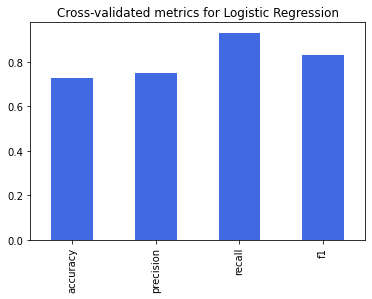

In [25]:
# Calculate cross-validated metrics
scoring_params = ["accuracy", "precision", "recall", "f1"]

cv_scores = {}

for scoring in scoring_params:
    values = cross_val_score(LogisticRegression(), X_conc, y_conc, cv=5, scoring=scoring)
    value = np.mean(values)
    cv_scores[scoring] = value

# Visualize cross-validated metrics
cv_metrics = pd.DataFrame(cv_scores,
                         index=[0])

cv_metrics.T.plot.bar(title="Cross-validated metrics for Logistic Regression",
                      legend=False,
                     color="royalblue");

#### KNN

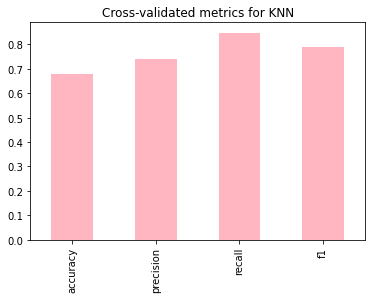

In [26]:
# Calculate cross-validated metrics
scoring_params = ["accuracy", "precision", "recall", "f1"]

cv_scores = {}

for scoring in scoring_params:
    values = cross_val_score(KNeighborsClassifier(), X_conc, y_conc, cv=5, scoring=scoring)
    value = np.mean(values)
    cv_scores[scoring] = value

# Visualize cross-validated metrics
cv_metrics = pd.DataFrame(cv_scores,
                         index=[0])

cv_metrics.T.plot.bar(title="Cross-validated metrics for KNN",
                      legend=False,
                     color="lightpink");

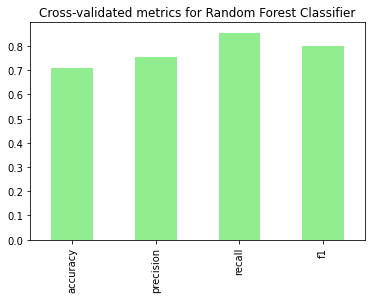

In [27]:
# Calculate cross-validated metrics
scoring_params = ["accuracy", "precision", "recall", "f1"]

cv_scores = {}

for scoring in scoring_params:
    values = cross_val_score(RandomForestClassifier(), X_conc, y_conc, cv=5, scoring=scoring)
    value = np.mean(values)
    cv_scores[scoring] = value

# Visualize cross-validated metrics
cv_metrics = pd.DataFrame(cv_scores,
                         index=[0])

cv_metrics.T.plot.bar(title="Cross-validated metrics for Random Forest Classifier",
                      legend=False,
                     color="lightgreen");

All our models are pretty similar. We are very quite good at corect prediction of patients that truly have liver disease. At the same time we are bad at predicting true negatives - patients without disease. To get better results we could consider hyperparameter tuning of our models. 